# NN Prediction
The title of the notebook should be coherent with file name. Namely, file name should be:

## Purpose
Explore the use of Neural Networks for the prediction of seismic events.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Setup

To create a new environment with all the necessary requirements use:
<br><br>
<code>
$ conda create --name <env> --file requirements.txt
</code>


### Library import
We import all the required Python libraries

In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython import get_ipython
from matplotlib import cm
from sklearn.model_selection import train_test_split
#from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

pdf = pd.DataFrame

%matplotlib qt
from sklearn.metrics import confusion_matrix
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

### Local library import
We import all the required local libraries

In [2]:
import model
from model import CalculateFeatures, SelectFeatures

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the other variables follow Python's guidelines.

In [3]:
USE_CACHED_FEATURES = True
MAGNITUDE_THRESHOLD = 6.0
WINDOW_SIZE= 100

## Data import
We retrieve all the required data for the analysis.

In [4]:
# delete cached features to generate new features

if model.features_in_cache() and USE_CACHED_FEATURES:
    print("Using cached features.")
    features = model.load_features_from_cache()
else:
    print("Calculating new features...")
    df = model.load_data('../../data/DATA_3_south.csv')
    df_model = CalculateFeatures(df, WINDOW_SIZE, trim_features=True, mag_threshold=MAGNITUDE_THRESHOLD)
    print("New features generated.")
    features = df_model.features
    features.to_csv("../../model/features_cache/features.csv", index=False)
    print("New features saved.")

Using cached features.


## Data processing

###  Feature selection

The features' data consist of 16 features, and there are two targets, only one is use on this

#### Features:
minimize


| Code |  Expression | Description |
| --- |  --- | --- |
|firstT | $T_{1}$   | First date.|
|lastT | $T_{n-1}$  | Last date.|
|meanMag | $M_{mean}=\dfrac{\sum_{i=1}^{n}( M_{i} )}{n}$  | Mean magnitude.|
|maxMag | $M_{max} = max(M)  $ | Max actual magnitude.|
|maxEMag | $M_{expected\;max} = \dfrac{a}{b}$ |Max expected magnitude.|
|a | ${\hat{\boldsymbol {\beta }}\in \operatorname {argmin} \limits _{\boldsymbol {\beta }}\sum _{i=1}^{n^{*}}\left[N_{i}-f\left(M^{*}_{i},{\boldsymbol {\beta }}\right)\right]^{2}}$<br> where <br> $f(M^{*},{\boldsymbol {\beta }})=10^{{\boldsymbol {\beta }_{1}-{\beta }_{2}M^{*}}}$<br>$M^{*}=$ unique elements of $M$ <br> $N=$ cardinality of each $M^{*}$<br><br> $a=\hat{{\boldsymbol {\beta }}_{1}}$| Levenberg–Marquardt algorithm, is used to solve a  of Gutenberg-Richter curve.|
|b | $b=\hat{{\boldsymbol {\beta }}_{2}}$ | Levenberg–Marquardt algorithm, is used to solve b slope of Gutenberg-Richter curve.|
|bStd | $σb = 2.3b\sqrt{\dfrac{\sum_{i=1}^{n}(M_{i}-M_{mean})^2}{n(n-1)}}$ | Standard deviation of b value.|
|grcStd | $\eta = \dfrac{\sum_{i=1}^{n}(M_{i}-M_{mean})^2}{n(n-1)}$ | Mean square deviation.|
|elapsedT | $\Delta T = T_{n-1} - T_{1}$  | Time elapsed of the last 'n' seismic events.|
|rateSqrtEnergy | $dE½ = \dfrac{\sum_{i=1}^{n}(10^{(11.8+1.5M_{i}})^{1/2}}{\Delta T}$ |Rate of square root of energy.|
|meanT | $\mu =\dfrac{\sum_{i=1}^{n}(\Delta T_{i} )}{n}$  | Mean of the differences of the times of each event.|
|meanTStd | $c = \sqrt{\dfrac{\sum_{i=1}^{n}(\Delta T_i- \mu )^2}{n-1}}$  | Standard Deviation of the differences of the times of each event.|
|magDef | $ΔM = M_{max} - M_{expected\;max} $  |Magnitude deficit.|
|zSeismicRateChange| $ z = \dfrac{N_{a}\Delta T_{b}-N_{b}\Delta T_{a}}{\sqrt{N_{a}\Delta T_{b}^2+N_{b}\Delta T_{a}^2}} $ <br> where<br> $N_{a}$ and $T_{a}$ are from the current window <br> $N_{b}$ and $T_{b}$ are from the next window| Seismic rate change proposed by Habermann and Wyss.|
|bSeismicRateChange| $β= \dfrac{N_a- \Lambda }{\sqrt{\Lambda }}$ <br> where <br> $\Lambda = N_{b}\times \dfrac{\Delta T_{a}}{\Delta T_{b}}$ | Seismic rate change proposed by Matthews and Reasenberg.|
|lastDMaxMag | $x6 = max\{M\}$, when $T \in{[T_{n-1}-d_{b}, T_{n-1})}$<br> where <br> $d_{b} =$ days to look behind | Max magnitude in the last d days.|
|pTMag[mag] | $x7 = 10^{-bm}$  | Probability of an earthquake equal or greater than a magnitude m. |

#### Targets:

| Code |  Expression | Description|
| --- | --- | --- |
|nextDMaxMag |  $y_{2} = max\{M\}$, when $T \in{[T_{n-1}, T_{n-1}+d_{a})}$  <br> where <br> $d_{a} =$ days to look ahead |  Max magnitude in the next $d_{a}$ days ahead .|
|nextDMaxMagT | $y_{2} = \begin{cases} 1 & \text{if } m >= M_{i}\\ 0& \text{if } m < M_{i}    \end{cases}$ |  Binary form of nextDMaxMag based on a [mag] threshold.|
|tTMag | $Te$|  Time-to-event in days of an earthquake equal or greater than [mag] !todo.|

$$y_{2} = max\{M\}$$
when
$$T \in{[T_{n-1}, T_{n-1}+d_{a})}$$
where
$$d_{a} =$$

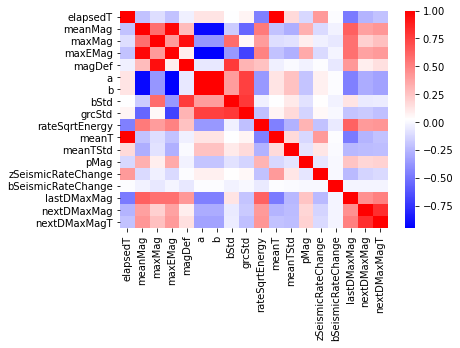

In [5]:
%matplotlib inline
X = features[model.FEATURES]
Y_CONTINUOUS = features[model.TARGETS.CONTINUOUS]
Y_CATEGORICAL = features[model.TARGETS.CATEGORICAL]
selected_features = SelectFeatures(features=X, targets=Y_CONTINUOUS, corr_threshold=.95, fixed_features=["b"])
X = X.to_numpy()
Y_CONTINUOUS = Y_CONTINUOUS.to_numpy()
Y_CATEGORICAL = Y_CATEGORICAL.to_numpy()
corrMatrix = features[model.ALL_FEATURES].corr()
sns.heatmap(corrMatrix,  cmap="bwr")
plt.show()
neg, pos = np.bincount(Y_CATEGORICAL.T[0])

###  Normalize and shorten data
(self.window_size * (T[1] - T[0])) / math.sqrt(self.window_size * T[0] + T[1])<br>

In [6]:
Y_CONTINUOUS_Scaler = MinMaxScaler()
X_Scaler = MinMaxScaler()
X_norm64 = X_Scaler.fit_transform(X)
Y_CONTINUOUS_norm64 = Y_CONTINUOUS_Scaler.fit_transform(Y_CONTINUOUS)
X_norm32 = X_norm64.astype(np.float32)
Y_CONTINUOUS_norm32 = Y_CONTINUOUS.astype(np.float32)

In [7]:
cmap = cm.get_cmap("viridis")
colors_continuous = list(map(cmap, Y_CONTINUOUS_norm64.T[0]))
color_categorical = list(map(cmap, Y_CATEGORICAL.T[0]*.90))
sizes = np.power(10, Y_CONTINUOUS_norm64.T[0])

In [8]:
RANDOM_STATE=42
X_norm_32_train, X_norm_32_test, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_test, Y_CATEGORICAL_train, Y_CATEGORICAL_test = train_test_split(
X_norm32, Y_CONTINUOUS_norm32, Y_CATEGORICAL, test_size=0.33, random_state=RANDOM_STATE)
X_norm_32_train, X_norm_32_val, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_val , Y_CATEGORICAL_train,Y_CATEGORICAL_val =train_test_split(X_norm_32_train, Y_CONTINUOUS_norm32_train, Y_CATEGORICAL_train, test_size=0.33, random_state=RANDOM_STATE)

In [9]:

def make_NN_model(metrics=model.METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  NN_model = keras.Sequential([
      keras.layers.Dense( 16, activation='relu',input_shape=(X_norm_32_train.shape[-1],)),
      # minimize
      keras.layers.Dropout(0.25),
      tf.keras.layers.Dense( 16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  NN_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return NN_model

In [10]:
NN_model = make_NN_model()
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [11]:
NN_model.predict(X_norm_32_train[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
NN_model.save_weights(initial_weights)


In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [13]:
NN_model = make_NN_model()
NN_model.load_weights(initial_weights)
baseline_history = NN_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val))

Epoch 1/200
9/9 [==============================] - 3s 170ms/step - loss: 0.8967 - tp: 1838.0000 - fp: 15623.0000 - tn: 17.0000 - fn: 92.0000 - accuracy: 0.1056 - precision: 0.1053 - recall: 0.9523 - auc: 0.3190 - prc: 0.0818 - val_loss: 0.8575 - val_tp: 798.0000 - val_fp: 7715.0000 - val_tn: 25.0000 - val_fn: 117.0000 - val_accuracy: 0.0951 - val_precision: 0.0937 - val_recall: 0.8721 - val_auc: 0.2423 - val_prc: 0.0706
Epoch 2/200
9/9 [==============================] - 0s 13ms/step - loss: 0.8344 - tp: 1449.0000 - fp: 15252.0000 - tn: 388.0000 - fn: 481.0000 - accuracy: 0.1046 - precision: 0.0868 - recall: 0.7508 - auc: 0.2991 - prc: 0.0763 - val_loss: 0.7932 - val_tp: 475.0000 - val_fp: 7445.0000 - val_tn: 295.0000 - val_fn: 440.0000 - val_accuracy: 0.0890 - val_precision:

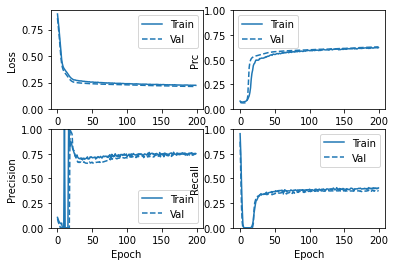

In [14]:
plot_metrics(baseline_history)

In [15]:
train_predictions_baseline = NN_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_baseline = NN_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

loss :  0.20880424976348877
tp :  591.0
fp :  178.0
tn :  11367.0
fn :  782.0
accuracy :  0.9256851077079773
precision :  0.768530547618866
recall :  0.43044427037239075
auc :  0.8951751589775085
prc :  0.6536990404129028


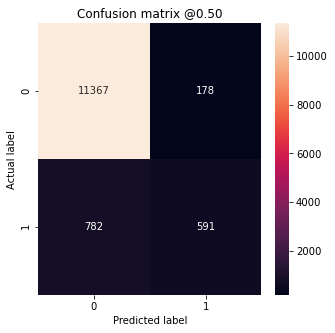

In [16]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

baseline_results = NN_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                  batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(NN_model.metrics_names, baseline_results):
  print(name, ': ', value)


plot_cm(Y_CATEGORICAL_test, test_predictions_baseline)

In [17]:
weight_for_0 = (1 / (features.shape[0]-Y_CATEGORICAL.sum())) * (features.shape[0] / 2.0)
weight_for_1 = (1 / Y_CATEGORICAL.sum()) * (features.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.64


In [18]:
weighted_model = make_NN_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val),
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
9/9 [==============================] - 3s 121ms/step - loss: 0.7392 - tp: 2515.0000 - fp: 15818.0000 - tn: 11367.0000 - fn: 788.0000 - accuracy: 0.4553 - precision: 0.1372 - recall: 0.7614 - auc: 0.6033 - prc: 0.2646 - val_loss: 0.8813 - val_tp: 915.0000 - val_fp: 7740.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.1057 - val_precision: 0.1057 - val_recall: 1.0000 - val_auc: 0.2874 - val_prc: 0.0754
Epoch 2/200
9/9 [==============================] - 0s 16ms/step - loss: 0.7218 - tp: 1930.0000 - fp: 15638.0000 - tn: 2.0000 - fn: 0.0000e+00 - accuracy: 0.1100 - precision: 0.1099 - recall: 1.0000 - auc: 0.4490 - prc: 0.

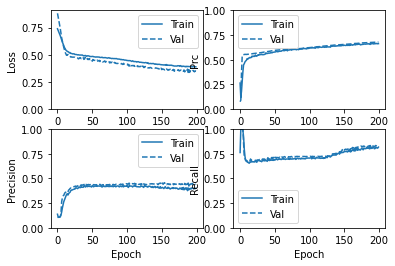

In [19]:
plot_metrics(weighted_history)


In [20]:
train_predictions_weighted = weighted_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

loss :  0.3503212034702301
tp :  1144.0
fp :  1439.0
tn :  10106.0
fn :  229.0
accuracy :  0.8708778619766235
precision :  0.4428958594799042
recall :  0.8332119584083557
auc :  0.9236626625061035
prc :  0.6950690150260925



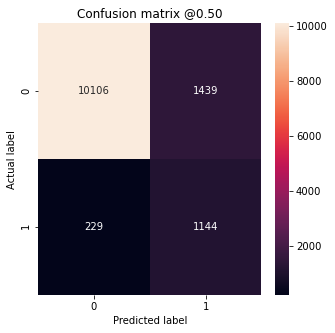

In [21]:
weighted_results = weighted_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                           batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_weighted)

In [22]:
pos_features = X_norm_32_train[Y_CATEGORICAL_train.T[0]]
neg_features = X_norm_32_train[~Y_CATEGORICAL_train.T[0]]

pos_labels = Y_CATEGORICAL_train[Y_CATEGORICAL_train.T[0]]
neg_labels = Y_CATEGORICAL_train[~Y_CATEGORICAL_train.T[0]]

In [23]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


(15640, 16)

In [24]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(31280, 16)

In [25]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [26]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [3.1929754e-02 3.8032788e-01 1.9512194e-01 3.8661590e-01 1.6857095e-01
 2.8391221e-01 2.8367755e-01 1.2075444e-01 1.4279018e-01 2.9392963e-02
 3.1929754e-02 1.5899828e-01 2.9721825e-06 3.8552806e-02 5.3292859e-01
 4.0000001e-01]

Label:  [ True]


In [27]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(model.BATCH_SIZE).prefetch(2)


In [28]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50146484375


In [29]:
resampled_steps_per_epoch = np.ceil(2.0*neg/model.BATCH_SIZE)
resampled_steps_per_epoch

35.0

In [30]:
resampled_model = make_NN_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_norm_32_val, Y_CATEGORICAL_val)).cache()
val_ds = val_ds.batch(model.BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=model.EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    validation_data=val_ds)

Epoch 1/200
35/35 [==============================] - 3s 42ms/step - loss: 0.6890 - tp: 21776.0000 - fp: 18949.0000 - tn: 28227.0000 - fn: 15646.0000 - accuracy: 0.5911 - precision: 0.5347 - recall: 0.5819 - auc: 0.6493 - prc: 0.5897 - val_loss: 0.6801 - val_tp: 694.0000 - val_fp: 2841.0000 - val_tn: 4899.0000 - val_fn: 221.0000 - val_accuracy: 0.6462 - val_precision: 0.1963 - val_recall: 0.7585 - val_auc: 0.8097 - val_prc: 0.4831

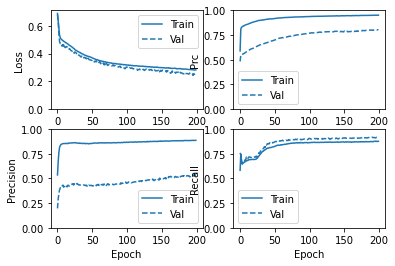

In [31]:
plot_metrics(resampled_history)

loss :  0.26086
tp :  1259
fp :  1141
tn :  10404
fn :  114
accuracy :  0.902849
precision :  0.524583
recall :  0.91697
auc :  0.964182
prc :  0.800791



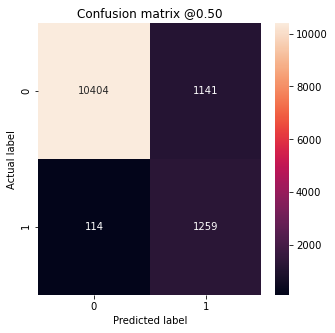

In [32]:
train_predictions_resampled = resampled_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                             batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', '%.6g' % value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_resampled)

## References
We report here relevant references:

1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2